In [1]:
import random
import os
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers

BATCH_SIZE = 32
VLD_BATCH_SIZE = 50
TRAIN_BATCH_SIZE = 30
SHUFFLE_BUFFER_SIZE = 32
IMG_SIZE = 224

TRAIN_DIR = './data/pre_512_30/train_images/'
TRAIN_DIR = './data/pre/train_images/'

SAVE_TO_DIR = './data/augment/'

TRAIN_DF = pd.read_csv('./data/train.csv')
TRAIN_SET = [[1]]
TRAIN_CNTS = [[300]]
VLD_CNTS = [[70]]
TRAIN_CNT = 1800
VLD_CNT = 198

for i in range(100):
    TRAIN_DF = TRAIN_DF.sample(frac = 1).reset_index(drop=True)

In [168]:
np.unique(TRAIN_DF['diagnosis'].values,return_counts = True)

(array([0, 1, 2, 3, 4], dtype=int64),
 array([1805,  370,  999,  193,  295], dtype=int64))

In [ ]:
TRAIN_DF['diagnosis'].unique()

In [ ]:
def divintosets(df, train, test, classes):
    traindic = {'filename' : [], 'class' : []}
    testdic = {'filename' : [], 'class' : []}
    clsid = 0
    for i in range(len(classes)):
        for j in range(len(classes[i])):
            lx = df['diagnosis'] == classes[i][j]
            fn = [x + '.png' for x in df['id_code'][lx].values]
            traindic['filename'] += fn[:train[i][j]]
            traindic['class'] += [str(clsid)] * train[i][j]
            testdic['filename'] += fn[train[i][j] : train[i][j] + test[i][j]]
            testdic['class'] += [str(clsid)] * test[i][j]
        clsid += 1
    train_df = pd.DataFrame(data = traindic)
    test_df = pd.DataFrame(data = testdic)
    for i in range(10):
        train_df = train_df.sample(frac = 1).reset_index(drop=True)
        test_df = test_df.sample(frac = 1).reset_index(drop=True)
    return train_df, test_df

train_df, test_df = divintosets(TRAIN_DF, TRAIN_CNTS, VLD_CNTS, TRAIN_SET) 

In [ ]:
train_df

In [ ]:
tran_gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 40,
                                                          width_shift_range = 0.2,
                                                          height_shift_range = 0.2,
                                                          shear_range = 0.2,
                                                          zoom_range = 0.2,
                                                          fill_mode = 'nearest')
tr_gen = tran_gen.flow_from_dataframe(train_df,
                                      target_size = (IMG_SIZE, IMG_SIZE), 
                                      directory = TRAIN_DIR,
                                      save_to_dir = SAVE_TO_DIR
                                 ) 

In [ ]:
#for img in tr_gen:
#    pass

In [2]:
p = './data/temp/'
df = pd.DataFrame({'filename' : ['xxx.png','yyy.png', 'zzz.png'], 'class' : ['7','8','9']})

In [33]:
def dumy(img):
    sigma = np.random.choice(25,1)[0]
    noise = np.random.normal(0,sigma,img.shape)
    img=cv2.addWeighted ( img.astype(float),1, noise ,1 ,0)
    lx = img < 0
    img[lx] = 0
    lx = img > 255
    img[lx] = 255
    return img

gen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range = 360,
                                                    preprocessing_function = dumy)
tr_gen = gen.flow_from_dataframe(df,
                                      target_size = (IMG_SIZE, IMG_SIZE), 
                                      directory = p,
                                      save_to_dir = p,
                                      class_mode = 'categorical',
                                 batch_size = 1,
                                 shuffle = True
                                 ) 

Found 3 validated image filenames belonging to 3 classes.


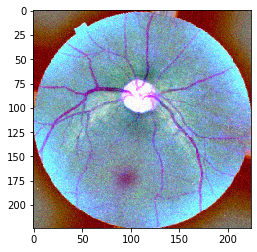

In [34]:
img = iter(tr_gen).next()
img = img[0].reshape(224,224,3).astype(int)
plt.imshow(img)

In [156]:
img[0].shape

(1, 224, 224, 3)

In [ ]:
model = models.Sequential()
#model.add(layers.Input((IMG_SIZE,IMG_SIZE,3)))
model.add(layers.GaussianNoise(stddev = 0.1,input_shape=(IMG_SIZE,IMG_SIZE,3))(training = False))

#model.compile()

model.summary()

In [ ]:
img = iter(tr_gen).next()
#img = model.predict(tr_gen)
img = tf.keras.layers.GaussianNoise(stddev = 224)(inputs = img, training = True)
#cv2.imwrite(p+ 'qqq.png')
img = img[0].numpy().reshape((224,224,3)).astype(int)
plt.imshow(img)

In [76]:
img[0].shape

(1, 224, 224, 3)

In [ ]:
gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255.)
tr_gen = gen.flow_from_dataframe(train_df, 
                                 target_size = (IMG_SIZE, IMG_SIZE), 
                                 class_mode = 'binary',
                                 directory = TRAIN_DIR,
                                 batch_size = TRAIN_BATCH_SIZE
                                 )
vld_gen = gen.flow_from_dataframe(test_df, 
                                 target_size = (IMG_SIZE, IMG_SIZE), 
                                 class_mode = 'binary',
                                 directory = TRAIN_DIR,
                                  batch_size = 1,
                                  shuffle = False
                                 )

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation = 'relu', input_shape=(IMG_SIZE,IMG_SIZE,3)))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
#model.add(layers.Dropout(0.4))
model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dense(1,activation = 'sigmoid'))

base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

model.summary()

In [ ]:

history = model.fit(tr_gen,
                    steps_per_epoch = TRAIN_CNT//TRAIN_BATCH_SIZE,
                    epochs = 3,
                    validation_data = vld_gen,
                    validation_steps = VLD_CNT//VLD_BATCH_SIZE)

In [ ]:
pred_df = TRAIN_DF.copy()
v = [x + '.png' for x in pred_df['id_code'].values]
pred_df['id_code'] = v
v = [str(x%2) for x in pred_df['diagnosis'].values]
pred_df['diagnosis'] = v
pred_df.columns = ['filename','class']
pred_gen = gen.flow_from_dataframe(pred_df, 
                                 target_size = (IMG_SIZE, IMG_SIZE), 
                                 class_mode = 'binary',
                                 directory = TRAIN_DIR,
                                  batch_size = 64,
                                  shuffle = False
                                 )

In [ ]:
import time
start = time.time()
vv = model.predict(pred_gen)
end = time.time()
print(end - start)

In [ ]:
for c1,c2 in vld_gen:
    break

In [ ]:
c1 = c1.reshape(224,224,3)

In [ ]:
plt.imshow(c1)

In [ ]:
TRAIN_DIR + test_df['filename'][0]

In [ ]:
file_path = TRAIN_DIR + test_df['filename'][0]
img = tf.io.read_file(file_path)
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
#img = (img/255)
#model.predict(tf.reshape(img,(1,224,224,3)))[0,0]
#test_df['class'][0]
print("min = {}, max = {}".format(np.min(img), np.max(img)))
plt.imshow(img)

In [ ]:
np.min(img)

In [ ]:
dictt = {'p' : [], 'c' : []}
acc = 0.0
for i in range(test_df.shape[0]):  
    x = vv[i][0]
    ccc = test_df.iat[i,1]
    if x > 0.5 and ccc == '2':
        acc += 1.0
    if x <=0.5 and ccc == '0':
        acc += 1.0
    dictt['p'].append(x)
    dictt['c'].append(ccc)       
print(acc / 198)  
newdf = pd.DataFrame(dictt)

In [ ]:
newdf

In [ ]:
test_df

In [ ]:
dictt = {'p' : [], 'c' : []}
acc = 0.0
for _,fn in test_df.iterrows():  
    file_path = TRAIN_DIR + fn['filename']
    img = tf.io.read_file(file_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = (img/255) - 1
    x = model.predict(tf.reshape(img,(1,224,224,3)))
    x = x[0,0]
    if x > 0.5 and fn['class'] == '2':
        acc += 1.0
    if x <=0.5 and fn['class'] == '0':
        acc += 1.0
    dictt['p'].append(x)
    dictt['c'].append(fn['class'])       
print(acc / 198)  
newdf = pd.DataFrame(dictt)

In [ ]:
newdf

In [ ]:
dictt['p'] += 4.9
print(dictt['p'])

In [ ]:
for _,row in test_df.iterrows():
    print(row['filename'],row['class'])
    break

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()